In [162]:
from scipy.io import loadmat
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [48]:
# load data from matlab
data = loadmat('LSTM_training.mat')
labels = loadmat('labels.mat')

In [266]:
all_label # 0-non-FM 1-FM+

array([0, 0, 0, ..., 1, 0, 1], dtype=uint8)

In [274]:
all_label[2289]

0

## dataframe

In [ ]:
df = pd.DataFrame(columns=['flip', 'frame', 'joint','x','y','fps','time','label'])
df

In [ ]:
for i in range(4438):
    line = data['DLC_sequences'][i][0]
    total_frame = line.shape[1]
    fps = total_frame/3
    label = labels['ans'][i][0]
    # print(line[0].shape)
    side = 'left' if i < 2219 else 'right'
    part = ['hip','ankle','feet']
    for j in range(total_frame):
        #print(row)
        row = pd.DataFrame([{'flip':i, 'frame':j, 'joint': side+'-hip','x':line[0][j],'y':line[1][j],'fps':fps,'time':3.0*j/total_frame,'label':label},
                           {'flip':i, 'frame':j, 'joint': side+'-ankle','x':line[2][j],'y':line[3][j],'fps':fps,'time':3.0*j/total_frame,'label':label},
                           {'flip':i, 'frame':j, 'joint': side+'-foot','x':line[4][j],'y':line[5][j],'fps':fps,'time':3.0*j/total_frame,'label':label}])
        df = pd.concat([df,row],ignore_index=True)


# Kinematics Features

In [49]:
action_seq = data['kf_filtered_sequences']

In [123]:
def get_angle_displacement(a):
    x = a['angle']
    y = a['angle_pre']
    return np.min(np.abs([y-x,y-x+2*np.pi, y-x-2*np.pi]))

In [82]:
def normalize_seq(rawx):
    min_x = np.min(rawx[0::2,:])
    max_x = np.max(rawx[0::2,:])
    min_y = np.min(rawx[1::2,:])
    max_y = np.max(rawx[1::2,:])

    new_x = np.zeros_like(rawx)
    new_x[0::2,:] = (rawx[0::2,:]-min_x)/(max_x-min_x)*2-1
    new_x[1::2,:] = (rawx[1::2,:]-min_y)/(max_y-min_y)*2-1

    
    return new_x

In [144]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [145]:
def build_features(rawx, T_max=90):
    rawx = normalize_seq(rawx)
    t = rawx.shape[1]
    if t<T_max:
        # print(t, T_max)
        rawx = np.pad(rawx,((0,0),(0, T_max-rawx.shape[1])), mode = 'constant')
    
    df = pd.DataFrame(rawx.T, columns = ['x0','y0','x1','y1','x2','y2'])
    total_frame = rawx.shape[1]
    fps = total_frame/3.0  # 3s clip

    # compute angle
    dot = (df['x0']-df['x1'])*(df['x2']-df['x1'])+(df['y0']-df['y1'])*(df['y2']-df['y1'])
    det = (df['x0']-df['x1'])*(df['y2']-df['y1'])-(df['y0']-df['y1'])*(df['x2']-df['x1'])
    df['angle']=(np.arctan2(det,dot)*np.pi ).map(lambda x: x+2*np.pi if x<0 else x)

    # angle features
    df['angle_pre'] = df['angle'].shift()
    df['angle_pre'].iloc[0]= df['angle'].iloc[0]
    df['angle_displacement']=df.apply(get_angle_displacement,axis=1)
    df['angle_velocity'] = df['angle_displacement'] * fps
    

    # Calculate the differences between rows
    diff = df.diff()
    diff.iloc[0] = 0
    df['angle_acceleration'] = diff['angle_velocity'] * fps
    df['angle_acceleration_2'] = df['angle_acceleration']**2

    # xy features
    df['displacement_0'] = np.sqrt(diff['x0']**2 + diff['y0']**2)
    df['displacement_1'] = np.sqrt(diff['x1']**2 + diff['y1']**2)
    df['displacement_2'] = np.sqrt(diff['x2']**2 + diff['y2']**2)

    df['velocity_x0'] = diff['x0'] * fps
    df['velocity_x1'] = diff['x1'] * fps
    df['velocity_x2'] = diff['x2'] * fps

    df['velocity_y0'] = diff['y0'] * fps
    df['velocity_y1'] = diff['y1'] * fps
    df['velocity_y2'] = diff['y2'] * fps

    df['speed_0'] = df['displacement_0'] * fps
    df['speed_1'] = df['displacement_1'] * fps
    df['speed_2'] = df['displacement_2'] * fps

    #new diff
    diff = df.diff()

    diff.iloc[0] = 0
    df['acceleration_x0'] = diff['velocity_x0'] * fps
    df['acceleration_x1'] = diff['velocity_x1'] * fps
    df['acceleration_x2'] = diff['velocity_x2'] * fps

    df['acceleration_y0'] = diff['velocity_y0'] * fps
    df['acceleration_y1'] = diff['velocity_y1'] * fps
    df['acceleration_y2'] = diff['velocity_y2'] * fps

    df['acceleration_x0_2'] = df['acceleration_x0']**2
    df['acceleration_x1_2'] = df['acceleration_x1']**2
    df['acceleration_x2_2'] = df['acceleration_x2']**2

    df['acceleration_y0_2'] = df['acceleration_y0']**2
    df['acceleration_y1_2'] = df['acceleration_y1']**2
    df['acceleration_y2_2'] = df['acceleration_y2']**2
    
    selected_columns = ['angle_velocity', 'angle_acceleration', 'angle_acceleration_2','velocity_x0',
       'velocity_x1', 'velocity_x2', 'velocity_y0', 'velocity_y1',
       'velocity_y2', 'speed_0', 'speed_1', 'speed_2', 'acceleration_x0',
       'acceleration_x1', 'acceleration_x2', 'acceleration_y0',
       'acceleration_y1', 'acceleration_y2', 'acceleration_x0_2',
       'acceleration_x1_2', 'acceleration_x2_2', 'acceleration_y0_2',
       'acceleration_y1_2', 'acceleration_y2_2']
    
    df[selected_columns] = scaler.fit_transform(df[selected_columns])
    
    return df.drop(columns=['angle_pre'])

# Seq2Seq Model

In [147]:
# sequence class to load and vectorize batches of data
class Features(keras.utils.Sequence):
    def __init__(self, action_sequences,batch_size):
        self.action_sequences = action_sequences
        self.batch_size = batch_size


    def __len__(self):
        return math.ceil(len(self.action_sequences) / self.batch_size)


    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low + self.batch_size, len(self.action_sequences))
        batch_sequences = self.action_sequences[low:high]
        return np.array([
            build_features(sequence[0])
                for sequence in batch_sequences])

In [205]:
loss_tracker = keras.metrics.Mean(name="loss")

class Seq2SeqModel(tf.keras.Model):
    # features: keypoint features of input sequences
    # fix_frame: the fixed legth of input sequences

    def __init__(self,features=35,timesteps=90,hidden_units=1024):
        super(Seq2SeqModel, self).__init__()
        self.hidden_units = hidden_units
        self.timesteps = timesteps
        self.features = features

        # 1 layer Bi-GRU encoder
        self.encoder = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_units // 2, return_state=True))
        self.batch_norm = tf.keras.layers.BatchNormalization()
        # 1 layer GRU decoder
        self.decoder =  tf.keras.layers.GRU(self.hidden_units, return_sequences=True)
        # prediction dense layer - regenerate only joints sequences
        self.pred_dense = tf.keras.layers.Dense(features, activation=None)

    def call(self, inputs):
        # inputs [batch_size, timesteps, features]
        encoder_outputs, forward_state, backward_state = self.encoder(inputs)
        final_state = tf.keras.layers.Concatenate(axis=-1)([forward_state, backward_state])
        final_state = self.batch_norm(final_state)
        decoder_outputs = self.decoder(tf.zeros_like(inputs), initial_state=final_state)
        regen_seq = self.pred_dense(decoder_outputs)

        return regen_seq, final_state

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            regen, enc = self(x, training=True)
            loss = self.compiled_loss(x, regen, regularization_losses=self.losses)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # update weights using the optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self, data):
        x = data
        regen, enc = self(x, training=False)
        loss = self.compiled_loss(x, regen, regularization_losses=self.losses)
        loss_tracker.update_state(loss)
        return {"loss": loss}

    @property
    def metrics(self):
        return [loss_tracker]

In [206]:
model = Seq2SeqModel()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="mae")
model.build(input_shape=(None, 90,35))
model.summary()

Model: "seq2_seq_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  multiple                 1686528   
 onal)                                                           
                                                                 
 batch_normalization_1 (Batc  multiple                 4096      
 hNormalization)                                                 
                                                                 
 gru_29 (GRU)                multiple                  3259392   
                                                                 
 dense_14 (Dense)            multiple                  35875     
                                                                 
Total params: 4,985,891
Trainable params: 4,983,843
Non-trainable params: 2,048
_________________________________________________________________


In [207]:
callbacks = [keras.callbacks.ModelCheckpoint("motion_tracking", save_best_only=True)]

In [267]:
all_label = labels['ans'].T[0]-1
batch_size = 50

## left leg

In [268]:
train = 400
div = 2219
val = 100

# Instantiate data Sequences for each split left leg
data_generator = Features(action_seq[:train], batch_size)
valid_generator = Features(action_seq[train:train+val], batch_size)
test_generator = Features(action_seq[div-val:div], batch_size)

train_label = all_label[:train]
val_label = all_label[train:train+val]
test_label = all_label[div-val:div]

In [223]:
train_loss = []
knn_score = []

for i in range(10):
  history = model.fit(data_generator, epochs=5, callbacks=callbacks, validation_data=valid_generator)
  loss = history.history['loss']
  train_loss.append(loss)
  train_feas = model.predict(data_generator, verbose=0)[1]
  knn = KNeighborsClassifier(n_neighbors=3,metric='cosine')
  knn.fit(train_feas,train_label)
  test_feas = model.predict(test_generator, verbose=0)[1]
  score = knn.score(test_feas,test_label)
  knn_score.append(score)  
  print("train loss:{},knn_score:{}".format(loss,score))

Epoch 1/5
8/8 [==============================] - ETA: 0s - loss: 0.2233

INFO:tensorflow:Assets written to: motion_tracking\assets


INFO:tensorflow:Assets written to: motion_tracking\assets


8/8 [==============================] - 73s 9s/step - loss: 0.2233 - val_loss: 0.2872
Epoch 2/5
8/8 [==============================] - ETA: 0s - loss: 0.2224

INFO:tensorflow:Assets written to: motion_tracking\assets


INFO:tensorflow:Assets written to: motion_tracking\assets


8/8 [==============================] - 70s 9s/step - loss: 0.2224 - val_loss: 0.2853
Epoch 3/5
8/8 [==============================] - 70s 9s/step - loss: 0.2267 - val_loss: 0.2964
Epoch 4/5
8/8 [==============================] - 68s 8s/step - loss: 0.2249 - val_loss: 0.2895
Epoch 5/5
8/8 [==============================] - ETA: 0s - loss: 0.2185

INFO:tensorflow:Assets written to: motion_tracking\assets


INFO:tensorflow:Assets written to: motion_tracking\assets


8/8 [==============================] - 81s 10s/step - loss: 0.2185 - val_loss: 0.2720
train loss:[0.22331641614437103, 0.2223585993051529, 0.22674618661403656, 0.22488978505134583, 0.21852844953536987],knn_score:0.24
Epoch 1/5
8/8 [==============================] - 61s 8s/step - loss: 0.2157 - val_loss: 0.2820
Epoch 2/5
6/8 [=====================>........] - ETA: 12s - loss: 0.2119

KeyboardInterrupt: 

In [218]:
train_feas

array([[-0.00290716,  0.04295841,  0.20273659, ..., -0.00187967,
         0.1656478 ,  0.13778055],
       [-0.10821806, -0.01430646,  0.12835613, ...,  0.12730983,
         0.19794205,  0.11693141],
       [ 0.2316527 ,  0.08854522,  0.29336664, ...,  0.0973044 ,
         0.14641404, -0.00468382],
       ...,
       [ 0.48973098,  0.20991616,  0.11261308, ..., -0.05766213,
         0.26345286,  0.26206997],
       [ 0.07847127, -0.05511357, -0.1083591 , ..., -0.02234076,
         0.27784058, -0.09951022],
       [-0.03987807, -0.0608051 , -0.03646784, ...,  0.22500607,
         0.2808551 , -0.01636124]], dtype=float32)

In [ ]:
Loss_all = []
for i in loss:
  Loss_all = Loss_all+i

In [ ]:
Loss_all = np.array(Loss_all)

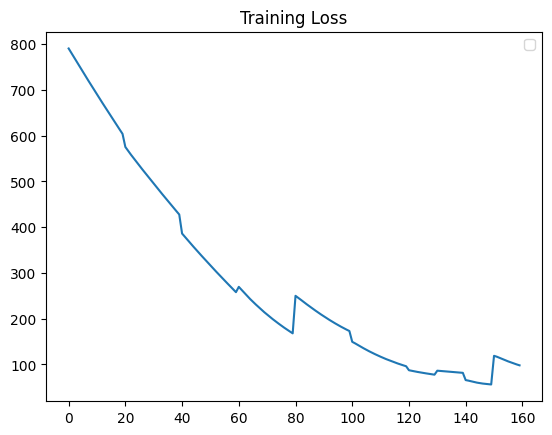

In [ ]:
epochs = range(0,Loss_all.shape[0])

plt.plot(epochs, Loss_all)
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_generator)

59/59 [==============================] - 30s 514ms/step - loss: 149.3657


149.36569213867188

In [ ]:
seq,enc = model.predict(data_generator)

50/50 [==============================] - 25s 508ms/step


In [177]:
model.save('left_leg_1layer_0')

INFO:tensorflow:Assets written to: left_leg_1layer_0\assets


INFO:tensorflow:Assets written to: left_leg_1layer_0\assets


## right leg

In [ ]:
# right leg
data_generator = Features(action_seq[:train] action_seq[div:div+train]]), batch_size)
valid_generator = Features(np.concatenate([action_seq[train:train+val], action_seq[div+train:div+train+val]]), batch_size)
test_generator = Features(np.concatenate([action_seq[div-val:div], action_seq[2*div-val:]]), batch_size)
left_leg_labels = all_label[:left_leg_end]
train_label = np.concatenate([all_label[:train], all_label[div:div+train]])
val_label = np.concatenate([all_label[train:train+val], all_label[div+train:div+train+val]])
test_label = np.concatenate([all_label[div-val:div], all_label[2*div-val:]])

# Auto-encoder AEC

In [183]:
loss_tracker = keras.metrics.Mean(name="loss")
class AEC(tf.keras.Model):
  def __init__(self,hidden_units=1024):
    super(AEC, self).__init__()
    # encoder
    self.fc1 = tf.keras.layers.Dense(hidden_units//2, activation='tanh') # 512
    self.fc2 = tf.keras.layers.Dense(hidden_units//4, activation='tanh') # 256
    self.fea = tf.keras.layers.Dense(hidden_units//8, activation='tanh') # 128
    # decoder
    self.fc3 = tf.keras.layers.Dense(hidden_units//4, activation='tanh')
    self.fc4 = tf.keras.layers.Dense(hidden_units//2, activation='tanh')

    self.pred = tf.keras.layers.Dense(hidden_units, activation=None)

  def call(self,inputs):
    # inputs [batch_size, hidden_units]
    x = self.fc1(inputs)
    x = self.fc2(x)
    feature = self.fea(x)

    x = self.fc3(feature)
    x = self.fc4(x)
    y = self.pred(x)

    return y, feature
  def train_step(self, data):
    x = data
    with tf.GradientTape() as tape:
      y, enc = self(x, training=True)
      loss = keras.losses.mean_squared_error(x, y)

    # compute gradients
    gradients = tape.gradient(loss, self.trainable_variables)
    # update weights using the optimizer
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    loss_tracker.update_state(loss)
    return {"loss": loss_tracker.result()}

  def test_step(self, data):
    x = data
    y, enc = self(x, training=False)
    loss = keras.losses.mean_squared_error(x, y)
    loss_tracker.update_state(loss)
    return {"loss": loss}

  @property
  def metrics(self):
    return [loss_tracker]

In [186]:
aec = AEC()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
aec.compile(optimizer=optimizer)
aec.build(input_shape=(None,1024))
aec.summary()

Model: "aec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  524800    
                                                                 
 dense_8 (Dense)             multiple                  131328    
                                                                 
 dense_9 (Dense)             multiple                  32896     
                                                                 
 dense_10 (Dense)            multiple                  33024     
                                                                 
 dense_11 (Dense)            multiple                  131584    
                                                                 
 dense_12 (Dense)            multiple                  525312    
                                                                 
Total params: 1,378,944
Trainable params: 1,378,944
Non-trainab

In [184]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/feature_autoencoder", save_best_only=True)]

In [ ]:
train_feas = model.predict(data_generator, verbose=0)[1]
test_feas = model.predict(test_generator, verbose=0)[1]
knn1_score = []

In [189]:
for i in range(5):
  history = aec.fit(train_feas,epochs=1, callbacks=callbacks,batch_size=100)
  _,low_feas = aec.predict(train_feas)

  knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
  knn.fit(low_feas,train_label)
  _,low_test_feas = aec.predict(test_feas)
  score = knn.score(low_test_feas,test_label)
  print("KNN Score",score)
  knn1_score.append(score)

8/8 [==============================] - ETA: 0s - loss: 0.0121WARNING:tensorflow:Can save best model only with val_loss available, skipping.


39/39 [==============================] - 1s 15ms/step
KNN Score 0.5479901558654635
8/8 [==============================] - ETA: 0s - loss: 0.0108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


39/39 [==============================] - 1s 15ms/step
KNN Score 0.5455291222313372
8/8 [==============================] - ETA: 0s - loss: 0.0098WARNING:tensorflow:Can save best model only with val_loss available, skipping.


39/39 [==============================] - 1s 15ms/step
KNN Score 0.5529122231337161
8/8 [==============================] - ETA: 0s - loss: 0.0087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


39/39 [==============================] - 1s 15ms/step
KNN Score 0.5463494667760459
8/8 [==============================] - ETA: 0s - loss: 0.0078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


39/39 [==============================] - 1s 15ms/step
KNN Score 0.5324036095159967


In [190]:
test_feas = model.predict(test_generator)[1]
_,low_test_feas = aec.predict(test_feas)
test_label = left_leg_labels[all_tr+val:]

39/39 [==============================] - 1s 15ms/step


In [ ]:
tr_feas = new_model.predict(data_generator)[1]
test_feas = new_model.predict(test_generator)[1]

knn.fit(tr_feas,tr_label)
knn.score(test_feas,test_label)

59/59 [==============================] - 29s 496ms/step


0.4756201881950385

In [219]:
low_feas.shape

(800, 128)

In [220]:
tr_label = all_label[:800]

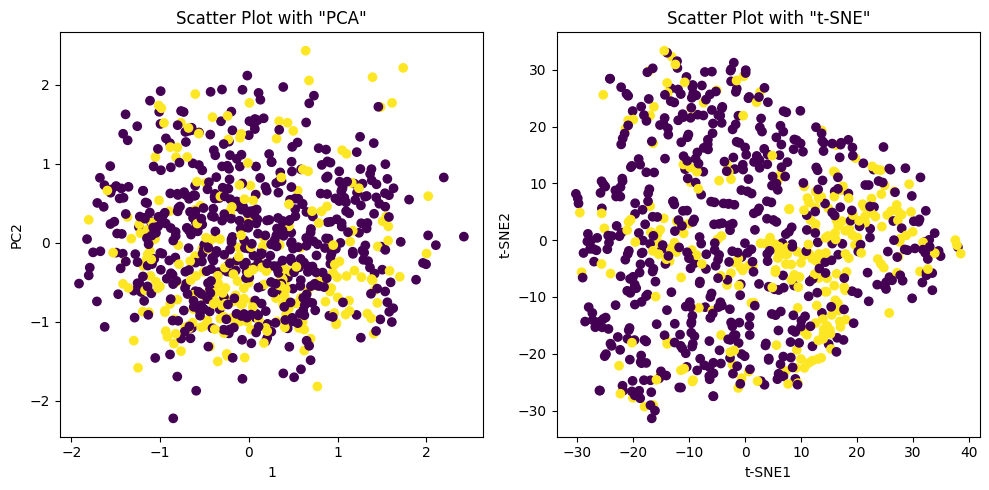

In [222]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(low_feas)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(low_feas)

# Plotting the reduced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=tr_label)
ax1.set_title('Scatter Plot with "PCA"')
ax1.set_xlabel('1')
ax1.set_ylabel('PC2')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=tr_label)
ax2.set_title('Scatter Plot with "t-SNE"')
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# feature knn

In [ ]:
feas = enc

In [ ]:
# Create an instance of KMeans
kmeans = KMeans(n_clusters=5)
# Fit the model to your data
kmeans.fit(feas)

cluster_labels_kmeans = kmeans.labels_
label = labels['ans'][:1000].T[0]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
pca = PCA(n_components=2)
X = pca.fit_transform(feas)

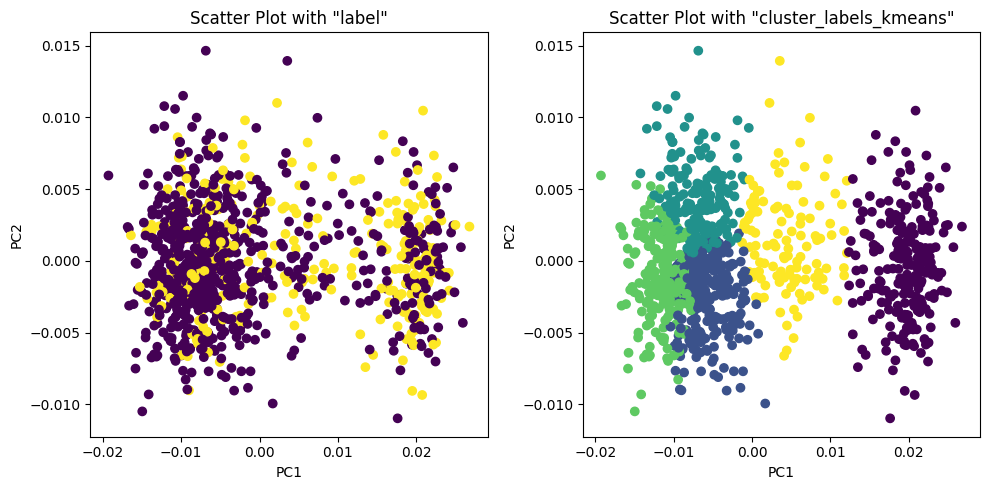

In [ ]:
# Plotting the reduced data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(X[:, 0], X[:, 1], c=label)
ax1.set_title('Scatter Plot with "label"')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels_kmeans)
ax2.set_title('Scatter Plot with "cluster_labels_kmeans"')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

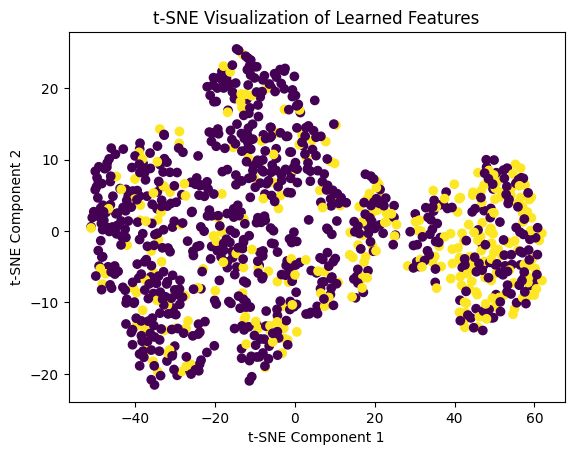

In [ ]:


# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(feas)

# Plot the t-SNE visualization
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label)
plt.title('t-SNE Visualization of Learned Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## original sequences data

In [ ]:
left_leg = action_seq[:2219]
all_label = labels['ans'].T[0]
left_leg_labels = all_label[:2219]

In [ ]:
for i in left_leg:


In [ ]:
ori_knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
knn.fit(low_feas,tr_label)


# only xy data

In [228]:
def normalize_seq(rawx, T_max=90):
    t = rawx.shape[1]
    if t<T_max:
        # print(t, T_max)
        rawx = np.pad(rawx,((0,0),(0, T_max-rawx.shape[1])), mode = 'constant')
        
    min_x = np.min(rawx[0::2,:])
    max_x = np.max(rawx[0::2,:])
    min_y = np.min(rawx[1::2,:])
    max_y = np.max(rawx[1::2,:])

    new_x = np.zeros_like(rawx)
    new_x[0::2,:] = (rawx[0::2,:]-min_x)/(max_x-min_x)*2-1
    new_x[1::2,:] = (rawx[1::2,:]-min_y)/(max_y-min_y)*2-1
    
    return new_x.T

In [229]:
# sequence class to load and vectorize batches of data
class Features(keras.utils.Sequence):
    def __init__(self, action_sequences,batch_size):
        self.action_sequences = action_sequences
        self.batch_size = batch_size


    def __len__(self):
        return math.ceil(len(self.action_sequences) / self.batch_size)


    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low + self.batch_size, len(self.action_sequences))
        batch_sequences = self.action_sequences[low:high]
        return np.array([
           normalize_seq(sequence[0])
                for sequence in batch_sequences])

In [230]:
train = 400
div = 2219
val = 100

# Instantiate data Sequences for each split left leg
data_generator = Features(action_seq[:train], batch_size)
valid_generator = Features(action_seq[train:train+val], batch_size)
test_generator = Features(action_seq[div-val:div], batch_size)

train_label = all_label[:train]
val_label = all_label[train:train+val]
test_label = all_label[div-val:div]

In [235]:
loss_tracker = keras.metrics.Mean(name="loss")

class Seq2SeqModel(tf.keras.Model):
    # features: keypoint features of input sequences
    # fix_frame: the fixed legth of input sequences

    def __init__(self,features=6,timesteps=90,hidden_units=1024):
        super(Seq2SeqModel, self).__init__()
        self.hidden_units = hidden_units
        self.timesteps = timesteps
        self.features = features

        # 1 layer Bi-GRU encoder
        self.encoder = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_units // 2, return_state=True))
        self.batch_norm = tf.keras.layers.BatchNormalization()
        # 1 layer GRU decoder
        self.decoder =  tf.keras.layers.GRU(self.hidden_units, return_sequences=True)
        # prediction dense layer - regenerate only joints sequences
        self.pred_dense = tf.keras.layers.Dense(features, activation=None)

    def call(self, inputs):
        # inputs [batch_size, timesteps, features]
        encoder_outputs, forward_state, backward_state = self.encoder(inputs)
        final_state = tf.keras.layers.Concatenate(axis=-1)([forward_state, backward_state])
        final_state = self.batch_norm(final_state)
        decoder_outputs = self.decoder(tf.zeros_like(inputs), initial_state=final_state)
        regen_seq = self.pred_dense(decoder_outputs)

        return regen_seq, final_state

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            regen, enc = self(x, training=True)
            loss = self.compiled_loss(x, regen, regularization_losses=self.losses)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # update weights using the optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self, data):
        x = data
        regen, enc = self(x, training=False)
        loss = self.compiled_loss(x, regen, regularization_losses=self.losses)
        loss_tracker.update_state(loss)
        return {"loss": loss}

    @property
    def metrics(self):
        return [loss_tracker]

In [240]:
model = Seq2SeqModel()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.95)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="mae")
model.build(input_shape=(None, 90,6))
model.summary()

Model: "seq2_seq_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirecti  multiple                 1597440   
 onal)                                                           
                                                                 
 batch_normalization_3 (Batc  multiple                 4096      
 hNormalization)                                                 
                                                                 
 gru_33 (GRU)                multiple                  3170304   
                                                                 
 dense_16 (Dense)            multiple                  6150      
                                                                 
Total params: 4,777,990
Trainable params: 4,775,942
Non-trainable params: 2,048
_________________________________________________________________


In [261]:
old_model = tf.keras.models.load_model('left_leg_1layer_0')

In [264]:
train_feas = old_model.predict(data_generator, verbose=0)[1]
test_feas = old_model.predict(test_generator, verbose=0)[1]

CancelledError: Graph execution error:

Detected at node 'backward_gru_24/PartitionedCall' defined at (most recent call last):
Node: 'backward_gru_24/PartitionedCall'
Function was cancelled before it was started
	 [[{{node backward_gru_24/PartitionedCall}}]] [Op:__inference_predict_function_1531515]

In [ ]:
  knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
  knn.fit(train_feas,train_label)
    

In [241]:
train_loss = []
knn_score = []

for i in range(10):
  history = model.fit(data_generator, epochs=5, callbacks=callbacks, validation_data=valid_generator)
  loss = history.history['loss']
  train_loss.append(loss)
  train_feas = model.predict(data_generator, verbose=0)[1]
  knn = KNeighborsClassifier(n_neighbors=1,metric='cosine')
  knn.fit(train_feas,train_label)
  test_feas = model.predict(test_generator, verbose=0)[1]
  score = knn.score(test_feas,test_label)
  knn_score.append(score)  
  print("train loss:{},knn_score:{}".format(loss,score))

Epoch 1/5
8/8 [==============================] - 57s 7s/step - loss: 0.5024 - val_loss: 0.4812
Epoch 2/5
8/8 [==============================] - 52s 7s/step - loss: 0.4688 - val_loss: 0.4764
Epoch 3/5
8/8 [==============================] - 52s 7s/step - loss: 0.3611 - val_loss: 0.3978
Epoch 4/5
8/8 [==============================] - 52s 7s/step - loss: 0.3171 - val_loss: 0.3721
Epoch 5/5
8/8 [==============================] - 52s 7s/step - loss: 0.2762 - val_loss: 0.3873
train loss:[0.5023524761199951, 0.46879151463508606, 0.36107999086380005, 0.31710681319236755, 0.27619561553001404],knn_score:0.32
Epoch 1/5
8/8 [==============================] - 52s 7s/step - loss: 0.2676 - val_loss: 0.4133
Epoch 2/5
8/8 [==============================] - 52s 7s/step - loss: 0.2606 - val_loss: 0.3919
Epoch 3/5
8/8 [==============================] - 52s 7s/step - loss: 0.2664 - val_loss: 0.3736
Epoch 4/5
8/8 [==============================] - 53s 7s/step - loss: 0.2644 - val_loss: 0.3764
Epoch 5/5
8/8 

In [246]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

In [258]:
# Create an instance of KMeans
kmeans = KMeans(n_clusters=2)
# Fit the model to your data
kmeans.fit(train_feas)
cluster_labels_kmeans = kmeans.labels_

E:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [259]:
train_label.shape

(400,)

In [260]:
adjusted_rand_score(cluster_labels_kmeans, train_label)

0.10626583614864865

In [251]:
ari

0.025400498855717556

In [ ]:
test_feas,test_label

In [243]:
knn = KNeighborsClassifier(n_neighbors=3,metric='cosine')
knn.fit(train_feas,train_label)
knn.score(test_feas,test_label)

0.28